## aoi classification  0-pass ，1-defect

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import random
import os,shutil

src_path="..\\tensorflow-classification\\dataset"

print(os.listdir(src_path))

#constant value
VALID_SPIT=0.2
IMAGE_SIZE=80
BATCH_SIZE=20

['defect', 'defect_clean', 'pass', 'test', 'test01', 'test_pass', 'train', 'train01']


### 載入data

In [2]:
label=[]
data=[]
counter=0
path="..\\tensorflow-classification\\dataset\\train01"
for file in os.listdir(path):
    image_data=cv2.imread(os.path.join(path,file), cv2.IMREAD_COLOR)
    image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
    if file.startswith("pass"):
        label.append(0)
    elif file.startswith("defect"):
        label.append(1)
    try:
        data.append(image_data/255)
    except:
        label=label[:len(label)-1]
    counter+=1
    if counter%200==0:
        print (counter," image data retreived")

data=np.array(data)
data=data.reshape((data.shape)[0],(data.shape)[1],(data.shape)[2],3)
label=np.array(label)
print (data.shape)
print (label.shape)

(198, 80, 80, 3)
(198,)


### split 20%

In [3]:
from sklearn.model_selection import train_test_split
train_data, valid_data, train_label, valid_label = train_test_split(
    data, label, test_size=0.2, random_state=42)
print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)

(158, 80, 80, 3)
(158,)
(40, 80, 80, 3)
(40,)


### use vgg model

In [4]:
from keras import applications
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(80, 80, 3))

vgg_model.summary()

C:\Users\nien\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0         
__________

### 建模

In [6]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation  = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 15,239,489
Trainable params: 15,239,489
Non-trainable params: 0
_________________________________________________________________


### training

In [8]:
from keras import backend as K
K.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
model.compile(loss='binary_crossentropy',optimizer=optimizers.adam(lr=1e-4),metrics=['acc'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
checkpoint_path = "check\\model.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
train_history=model.fit(train_data, train_label, epochs=20, batch_size=BATCH_SIZE, callbacks = [cp_callback])

Epoch 1/20
140/158 [=========================>....] - ETA: 1s - loss: 0.3969 - acc: 0.7786
Epoch 00001: saving model to check\model.ckpt
158/158 [==============================] - 10s 63ms/step - loss: 0.3778 - acc: 0.7975
Epoch 2/20
140/158 [=========================>....] - ETA: 0s - loss: 0.0365 - acc: 0.9786
Epoch 00002: saving model to check\model.ckpt
158/158 [==============================] - 2s 10ms/step - loss: 0.0333 - acc: 0.9810
Epoch 3/20
140/158 [=========================>....] - ETA: 0s - loss: 0.1772 - acc: 0.9286
Epoch 00003: saving model to check\model.ckpt
158/158 [==============================] - 2s 10ms/step - loss: 0.1596 - acc: 0.9367
Epoch 4/20
140/158 [=========================>....] - ETA: 0s - loss: 0.0169 - acc: 1.0000
Epoch 00004: saving model to check\model.ckpt
158/158 [==============================] - 2s 10ms/step - loss: 0.0266 - acc: 0.9937
Epoch 5/20
140/158 [=========================>....] - ETA: 0s - loss: 0.0055 - acc: 1.0000
Epoch 00005: saving 

### 儲存模型

In [11]:
model.save("model01.h5")

### 模糊矩陣

In [12]:
Y_pred = model.predict(valid_data)
predicted_label=np.round(Y_pred,decimals=2)

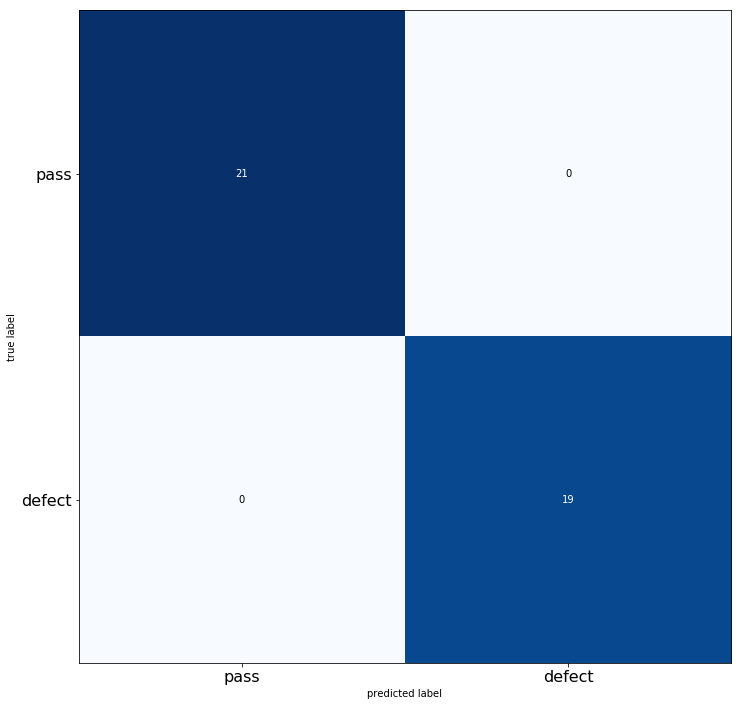

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix

# Get the confusion matrix

CM = confusion_matrix(valid_label, Y_pred.round())
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12, 12))
plt.xticks(range(2), ['pass', 'defect'], fontsize=16)
plt.yticks(range(2), ['pass', 'defect'], fontsize=16)
plt.show()

## 引入test data

In [21]:
import os
import cv2
import numpy as np
import pandas as pd

test_data=[]
id=[]
counter=0
IMAGE_SIZE=80

#for file in os.listdir("..\\tensorflow-classification\\dataset\\test_pass"):
for file in os.listdir("..\\tensorflow-classification\\dataset\\test01"):
    pic = "..\\tensorflow-classification\\dataset\\test01\\" + file
    image_data=cv2.imread(os.path.join(pic), cv2.IMREAD_COLOR)
    
    try:
        image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
        test_data.append(image_data/255)
        id.append((file.split("."))[0])
    except:
        print ("ek gaya")
    counter+=1


test_data=np.array(test_data)
print (test_data.shape)
test_data=test_data.reshape((test_data.shape)[0],(test_data.shape)[1],(test_data.shape)[2],3)
dataframe_output=pd.DataFrame({"id":id})

(18, 80, 80, 3)


In [22]:
predicted_labels=model.predict(test_data)
predicted_labels=np.round(predicted_labels,decimals=2)
labels=[1 if value>0.5 else 0 for value in predicted_labels]

In [23]:
dataframe_output["label"]=labels
print(dataframe_output)
dataframe_output.to_csv('result.csv')

        id  label
0   defect      1
1   defect      1
2   defect      1
3   defect      1
4   defect      1
5   defect      1
6   defect      1
7   defect      1
8   defect      1
9     pass      0
10    pass      0
11    pass      0
12    pass      0
13    pass      0
14    pass      0
15    pass      0
16    pass      0
17    pass      0


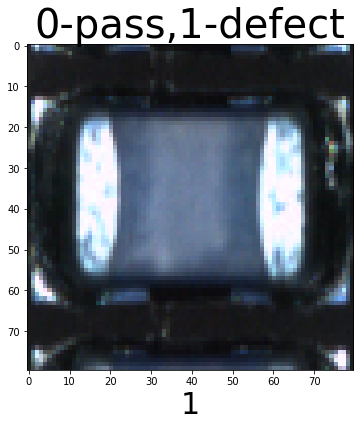

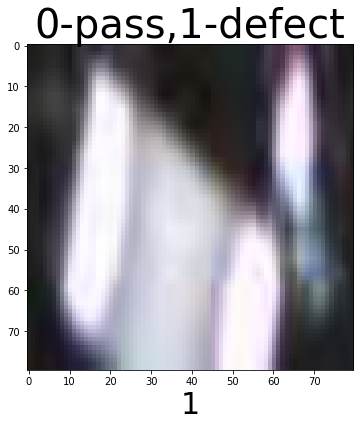

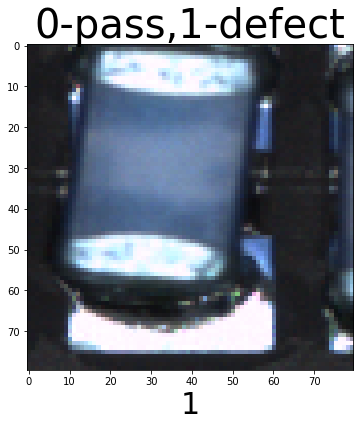

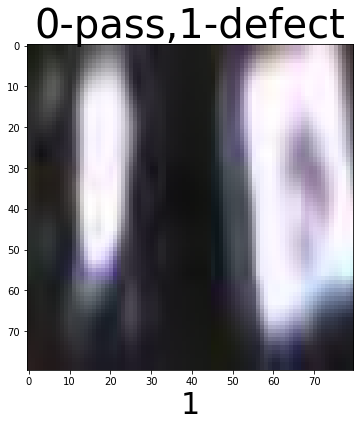

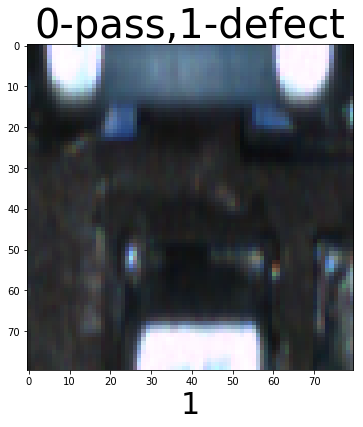

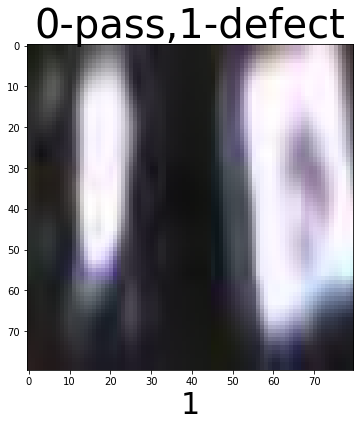

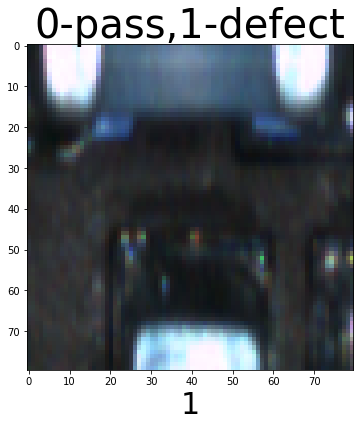

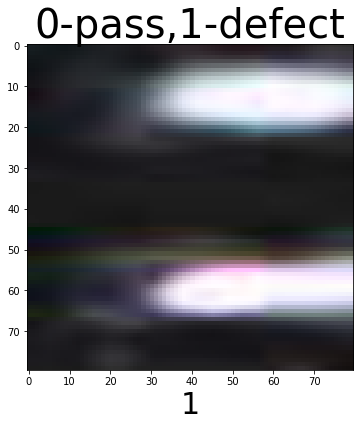

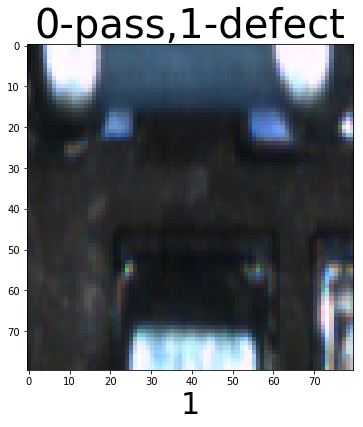

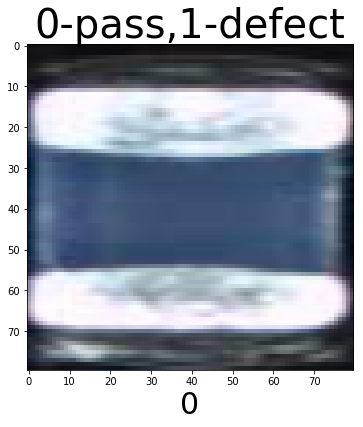

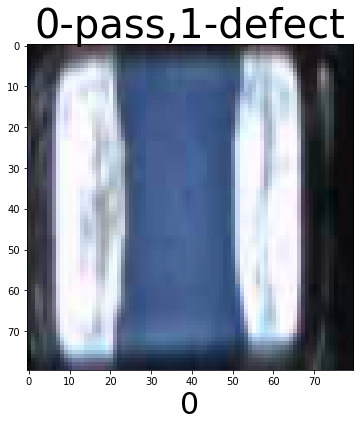

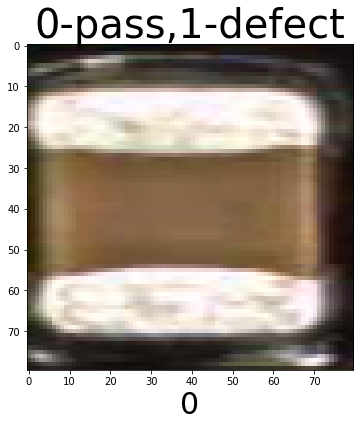

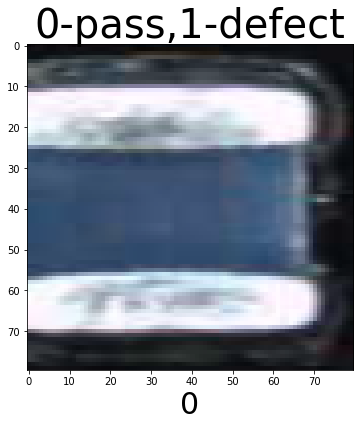

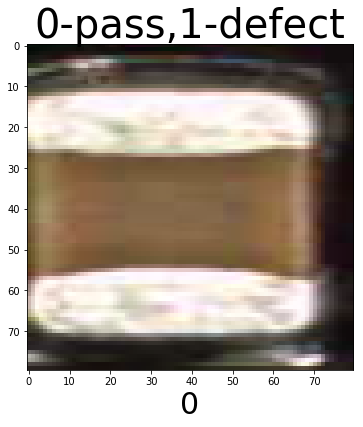

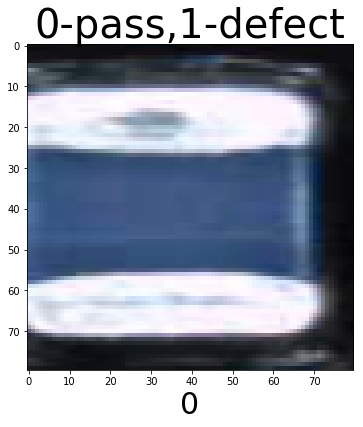

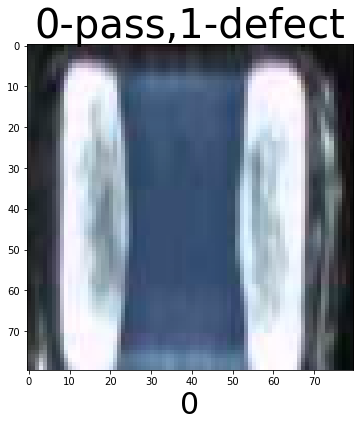

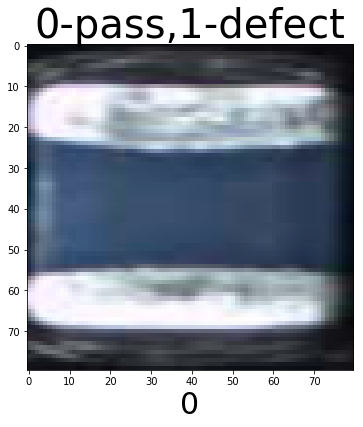

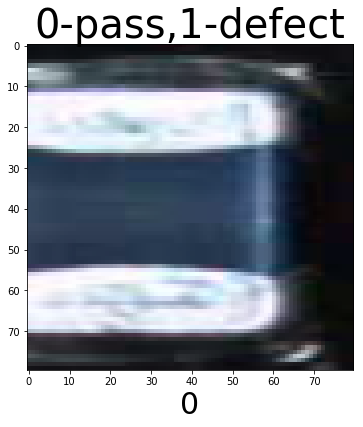

IndexError: index 18 is out of bounds for axis 0 with size 18

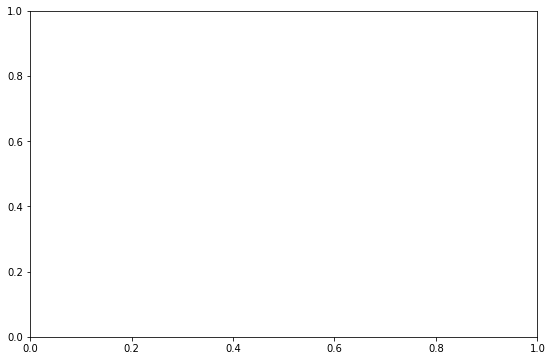

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(40):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 2)
    plt.imshow(test_data[i])
#     plt.xlabel('label')
    plt.xlabel(dataframe_output["label"][i],fontsize=30)
    plt.title('0-pass,1-defect',fontsize=40)
    plt.show()

### 需要去csv檔案寫上答案

In [26]:
import csv
import os
import numpy as np
correct = 0
with open('result.csv', newline='') as csvfile:    
    rows = csv.DictReader(csvfile)
    for row in rows:
        if row['label'] == row['answer']:
            correct += 1
        else:
            print(row['id'] + " 答案是:" + row['answer'] + " 誤判成: " + row['label'])
            
print("--------------------------------------")
print("準確率 ： %.8f" %(correct/(rows.line_num-1)))

--------------------------------------
準確率 ： 1.00000000


## 使用model做驗證

In [1]:
from keras.models import load_model
import os
import cv2
import numpy as np
import pandas as pd
import csv
import os
import numpy as np

C:\Users\nien\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [1]:
from keras.models import load_model
model = load_model('model.h5')
print(model.input)

C:\Users\nien\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Tensor("vgg16_input:0", shape=(?, 80, 80, 3), dtype=float32)


In [2]:
model = load_model('model.h5')

test_data=[]
id=[]
counter=0
IMAGE_SIZE=80

for file in os.listdir("..\\tensorflow-classification\\dataset\\test_pass"):
    
    pic = "..\\tensorflow-classification\\dataset\\test_pass\\" + file
    image_data=cv2.imread(os.path.join(pic), cv2.IMREAD_COLOR)
    
    try:
        image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
        test_data.append(image_data/255)
        id.append((file.split("."))[0])
    except:
        print ("WHAT THE FUCK")
    counter+=1


test_data=np.array(test_data)
print (test_data.shape)
test_data=test_data.reshape((test_data.shape)[0],(test_data.shape)[1],(test_data.shape)[2],3)
dataframe_output=pd.DataFrame({"id":id})

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
(864, 80, 80, 3)


In [35]:
predicted_labels=model.predict(test_data)
predicted_labels=np.round(predicted_labels,decimals=2)
labels=[1 if value>0.5 else 0 for value in predicted_labels]

dataframe_output["label"]=labels
print(dataframe_output)
dataframe_output.to_csv('result1.csv')

        id  label
0       D1      0
1      D10      0
2    D1001      0
3    D1003      0
4    D1005      0
5    D1007      0
6    D1009      0
7     D101      0
8    D1011      0
9    D1012      0
10   D1015      0
11   D1017      0
12   D1018      0
13   D1021      0
14   D1023      0
15   D1025      0
16   D1026      0
17   D1029      0
18    D103      0
19   D1031      0
20   D1033      0
21   D1035      0
22   D1037      0
23   D1039      0
24   D1041      0
25   D1043      0
26   D1045      0
27   D1047      0
28   D1049      0
29    D105      0
..     ...    ...
834   D947      0
835   D949      0
836    D95      0
837   D951      0
838   D952      0
839   D955      0
840   D957      0
841   D959      0
842   D961      0
843   D963      0
844   D965      0
845   D967      0
846   D969      0
847    D97      0
848   D971      0
849   D973      0
850   D975      0
851   D977      0
852   D979      0
853    D98      0
854   D981      0
855   D983      0
856   D985      0
857   D987

In [42]:
correct = 0
with open('result.csv', newline='') as csvfile:    
    rows = csv.DictReader(csvfile)
    for row in rows:
        if row['label'] == row['answer']:
            correct += 1
        else:
            print(row['id'] + " 答案是:" + row['answer'] + " 誤判成: " + row['label'])
            
print("--------------------------------------")
print("準確率 ： %.8f" %(correct/(rows.line_num-1)))

D439 答案是:0 誤判成: 1
D557 答案是:0 誤判成: 1
D764 答案是:0 誤判成: 1
--------------------------------------
準確率 ： 0.99652778
